In [1]:
import os
from os.path import join

import pandas as pd

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [2]:
train_data_path = join('./input', 'train.csv')
test_data_path = join('./input', 'test.csv')

# 1.데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴본다.
1. ID : 집을 구분하는 번호
1. date : 집을 구매한 날짜
1. price : 타겟 변수인 집의 가격
1. bedrooms : 침실의 수
1. bathrooms : 침실당 화장실 개수
1. sqft_living : 주거 공간의 평방 피트
1. sqft_lot : 부지의 평방 피트
1. floors : 집의 층 수
1. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
1. view : 집이 얼마나 좋아 보이는지의 정도
1. condition : 집의 전반적인 상태
1. grade : King County grading 시스템 기준으로 매긴 집의 등급
1. sqft_above : 지하실을 제외한 평방 피트
1. sqft_basement : 지하실의 평방 피트
1. yr_built : 집을 지은 년도
1. yr_renovated : 집을 재건축한 년도
1. zipcode : 우편번호
1. lat : 위도
1. long : 경도
1. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
1. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [4]:
y = train['price']
del train['price'] # 가격을 별도로 저장 후, 원본에서 삭제

In [5]:
train_len = len(train)
data = pd.concat((train, test), axis=0) # 길이 따로 저장 후, 둘을 합침
# print(train.head())
# print(data.head())
data['date'][0:10]

0    20141013T000000
1    20150225T000000
2    20150218T000000
3    20140627T000000
4    20150115T000000
5    20150403T000000
6    20140527T000000
7    20140528T000000
8    20141007T000000
9    20150312T000000
Name: date, dtype: object

In [6]:
print(data.shape)
data.tail() # id 왼쪽의 숫자도 15000 + 6000인거 같음

(21503, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


# 2. 간단한 전처리
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 한다.

### 결측치 확인
먼제 데이터에 결측치가 있는지를 확인한다.
missingno 라이브러리의 matrix함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있다.

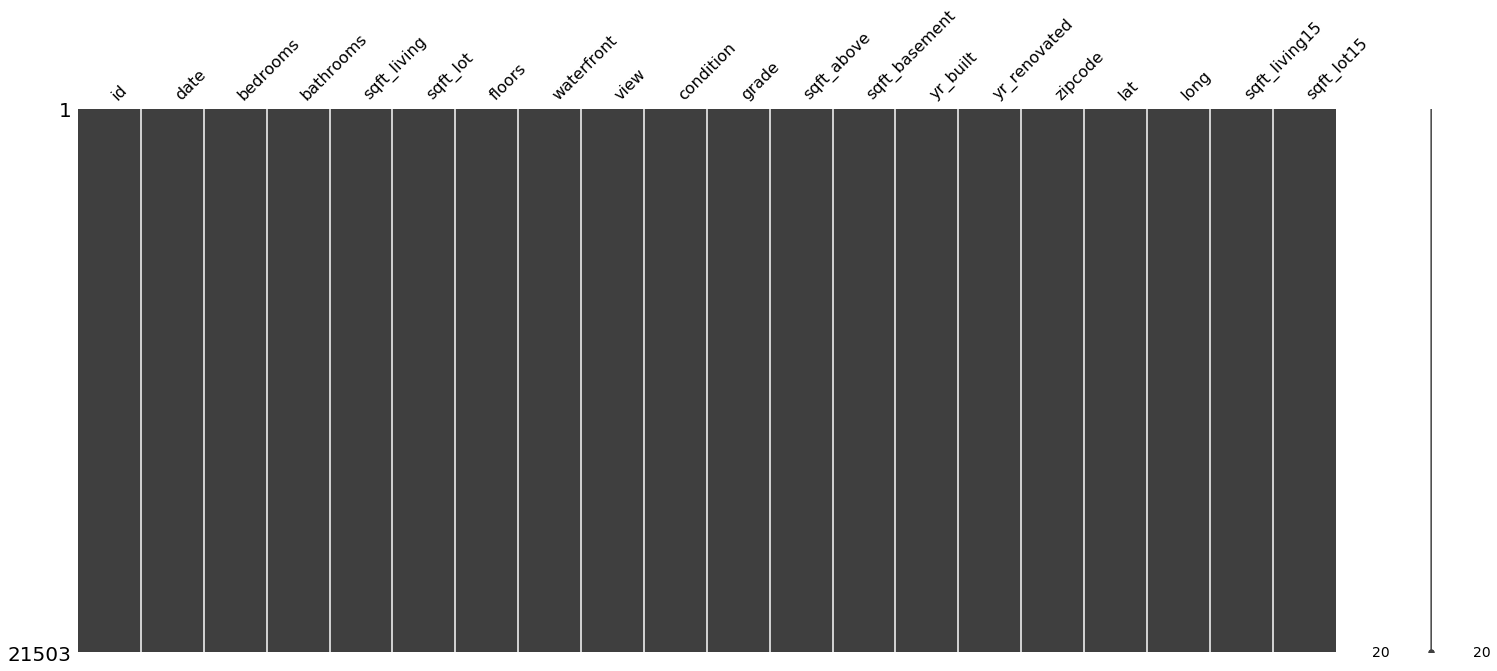

In [7]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴본다.

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values))) 
    # len(data.loc[pd.isnull(data[c]), c].values) - null이 있는 행, 해당 열의 값을 길이로 반환함   
    # df.loc[행인덱스, 열인덱스] 

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리

id 변수는 모델이 집값을 예측하는 데 도움을 주지 않으므로 제거한다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만든다.

In [9]:
sub_id = data['id'][train_len:] # train만 저장
# print(sub_id) 6천개만 저장(test)
# data['id'][:] # 전체(21503개가 나옴)

In [10]:
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, : ]

## 3.모델링

<b>Average Blending</b><br>
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만든다.

In [12]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':lightgbm, 'name':'LightGBM'},{'model':xgboost, 'name':'XGBoost'},{'model':gboost, 'name': 'GradientBoosting'}]

## Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가한다.

In [13]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)),
                                                 kf = kfold))

In [14]:
get_cv_score(models)

Model LightGBM CV score : 0.8748
Model XGBoost CV score : 0.8544
Model GradientBoosting CV score : 0.8574


<b>Make Submission</b>

회귀 모델의 경우에는 cross_val_score 함수가 R^2를 반환한다.
R^2 값이 1에 가까울수록 모델이 데이터를 잘표현함을 나타낸다. 3개 트리 모델이상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있다.
훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만든다.

In [15]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
        
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [16]:
y_pred = AveragingBlending(models, x, y, sub)

In [17]:
sub = pd.DataFrame(data={'id':sub_id, 'price':y_pred})

In [18]:
sub.to_csv('submission_baseline_no_preprocessing_light_GBM + XGB + gboost.csv', index=False)

## RMSE score

1등 :  67,375 <br>
1st light GBM : 121,183(172/291등) - 04/04 <br>
1st GBM + XGB 124,199 - 04/05 <br>
1st ligth GBM + Gboost : 126,850 - 04/04 <br>
1st GBM + XGB + Gboost : 129,560 - 04/05 <br>
1st XGB : 138,680 (237등/291) - 04/04 <br>
1st Gboost : 144,955 - 04/04 <br>
2nd Keras : 237,603 (263등/290) - 04/03


